In [76]:
import sys

# laptop
sys.path.append( '/home/greg/current/NMEG_utils/py_modules/' )

# UNM desktop
#sys.path.append( '..\\NMEG_utils\\py_modules\\' )
#af_path = 'C:\\Research_Flux_Towers\\Ameriflux_files\\'
#fig_path = 'figures\\multiyear_figs\\'

import load_nmeg as ld
import transform_nmeg as tr
import plot_nmeg as nmegplt
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
#import ipdb as ipdb

%matplotlib inline
sns.set_style("white")


In [77]:
data_path = '~/data/current/NMEG_utils/processed_data/daily_aflx/'
fig_path = '../figures/multiyear_figs/'
# Years to load
start = 2007
end = 2015
sites = ['Seg', 'Ses', 'Sen', 'Wjs', 'Mpj', 'Mpg', 'Vcp', 'Vcm']
# Fill a dict with multiyear dataframes for each site in sites
daily = { x : 
         ld.load_local_daily_file( data_path + 'US-' + x + '_daily_aflx.csv')
         for x in sites }
d = pd.Panel(daily)

Parsing ~/data/current/NMEG_utils/processed_data/daily_aflx/US-Seg_daily_aflx.csv
Parsing ~/data/current/NMEG_utils/processed_data/daily_aflx/US-Ses_daily_aflx.csv
Parsing ~/data/current/NMEG_utils/processed_data/daily_aflx/US-Sen_daily_aflx.csv
Parsing ~/data/current/NMEG_utils/processed_data/daily_aflx/US-Wjs_daily_aflx.csv
Parsing ~/data/current/NMEG_utils/processed_data/daily_aflx/US-Mpj_daily_aflx.csv
Parsing ~/data/current/NMEG_utils/processed_data/daily_aflx/US-Mpg_daily_aflx.csv
Parsing ~/data/current/NMEG_utils/processed_data/daily_aflx/US-Vcp_daily_aflx.csv
Parsing ~/data/current/NMEG_utils/processed_data/daily_aflx/US-Vcm_daily_aflx.csv


## Remove Mixed Conifer data after the fire

In [78]:
# Note original dataframe shape preserved (but nans are produced)
d.Vcm = d.Vcm[ d.Vcm.index < dt.datetime( 2013, 5, 3) ]
d.Vcm.tail()

GPP_g_int  RECO_g_int  FC_F_g_int  ET_mm_24hint_0  P_F_sum  \
2015-12-28        NaN         NaN         NaN             NaN      NaN   
2015-12-29        NaN         NaN         NaN             NaN      NaN   
2015-12-30        NaN         NaN         NaN             NaN      NaN   
2015-12-31        NaN         NaN         NaN             NaN      NaN   
2016-01-01        NaN         NaN         NaN             NaN      NaN   

            TA_F_avg  RH_F_avg  SW_IN_F_avg  RNET_F_avg  VPD_F_avg  PAR_avg  \
2015-12-28       NaN       NaN          NaN         NaN        NaN      NaN   
2015-12-29       NaN       NaN          NaN         NaN        NaN      NaN   
2015-12-30       NaN       NaN          NaN         NaN        NaN      NaN   
2015-12-31       NaN       NaN          NaN         NaN        NaN      NaN   
2016-01-01       NaN       NaN          NaN         NaN        NaN      NaN   

            TA_F_min  VPD_F_min  TA_F_max  VPD_F_max  ET_mm_dayint  \
2015-12-28       NaN        NaN       NaN        NaN           NaN   
2015-12-29       NaN        NaN       NaN        NaN           NaN   
2015-12-30       NaN        NaN       NaN        NaN           NaN   
2015-12-31       NaN        NaN       NaN        NaN           NaN   
2016-01-01       NaN        NaN       NaN        NaN           NaN   

            PET_mm_dayint  
2015-12-28            NaN  
2015-12-29            NaN  
2015-12-30            NaN  
2015-12-31            NaN  
2016-01-01            NaN

## Plot NEE timeseries

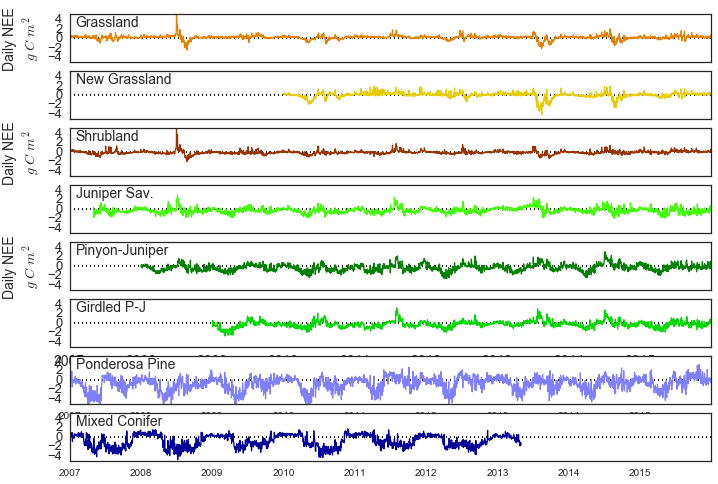

In [30]:
ylims = [ -5, 5 ]
fig1 = plt.figure(figsize=( 11.5, 8 ), dpi=150, facecolor='w', edgecolor='k')
ax = nmegplt.plot_tseries( d, 'FC_F_g_int', 2.5, fig1, 'Daily NEE\n$g\ C\ m^2$', ylims=ylims)

#plt.show()
fig1.savefig( fig_path + 'NMEG_daily_FC.svg')
fig1.savefig( fig_path + 'NMEG_daily_FC.png', dpi=200)

## Plot partitioned timeseries

* GPP is negative

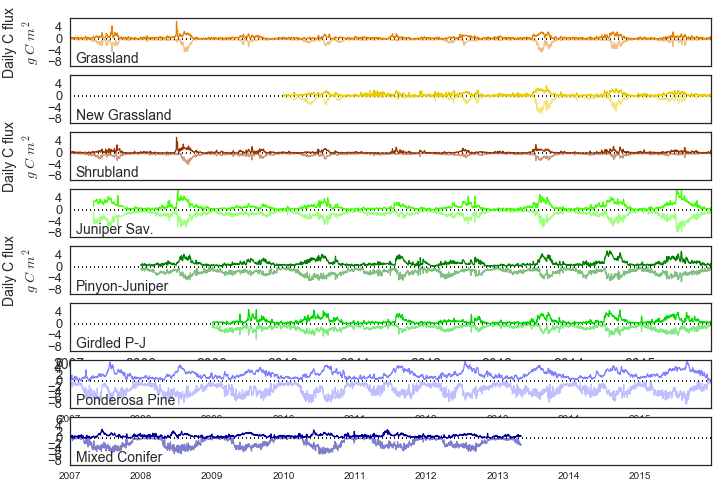

In [31]:
ylims = [ -9, 7 ]

fig2 = plt.figure(figsize=( 11.5, 8 ), dpi=150, facecolor='w', edgecolor='k')
ax = nmegplt.plot_tseries( d, ['RECO_g_int', 'GPP_g_int'], -8, fig2, 'Daily C flux\n$g\ C\ m^2$', ylims=ylims)
for j in range(0,6):
    ax[j].yaxis.set_ticks(np.arange(-8, 6, 4))

#plt.show()
fig2.savefig( fig_path + 'NMEG_daily_part.svg')
fig2.savefig( fig_path + 'NMEG_daily_part.png', dpi=200)

## Calculate multi-year statistics

In [80]:
# To assess drought we'll need to modify the climatologies by
# calculating means for drought/non-drought years
def mod_clim( clim ):
    clim[ 'predrght_mean' ] = clim[['2007', '2008', '2009', '2010']].mean(axis=1)
    clim[ 'drght_mean' ] = clim[['2011', '2012']].mean(axis=1)
    clim[ 'postdrght_mean' ] = clim[['2013', '2014']].mean(axis=1)
    # Calculate anomalies from allyear mean for drought-post-drought
    clim[ 'predrght_mean_anom' ] = clim.predrght_mean - clim.allyr_mean
    clim[ 'drght_mean_anom' ] = clim.drght_mean - clim.allyr_mean
    clim[ 'postdrght_mean_anom' ] = clim.postdrght_mean - clim.allyr_mean
    clim[ 'drght_mean_preanom' ] = clim.drght_mean - clim.predrght_mean
    clim[ 'postdrght_mean_preanom' ] = clim.postdrght_mean - clim.predrght_mean

    for i in range(start, end):
        # column for each year
        clim[ str(i) ] = clim[ str(i )]
        clim[ str(i) + '_anom' ] = clim[ str(i )] - clim.allyr_mean
        clim[ str(i) + '_preanom' ] = clim[ str(i )] - clim.predrght_mean
    
    return clim

### Get modified climatologies for FC, GPP, RECO, etc

In [82]:
# Create dictionaries with modified climatology (see mod_clim)
# for each site
fc_clim = { s : mod_clim(tr.var_climatology( d[s].FC_F_g_int )) for s in sites}
gpp_clim = { s : mod_clim(tr.var_climatology( d[s].GPP_g_int )) for s in sites}
re_clim = { s : mod_clim(tr.var_climatology( d[s].RECO_g_int )) for s in sites}
p_clim = { s : mod_clim(tr.var_climatology( d[s].P_F_sum )) for s in sites}
vpd_clim = { s : mod_clim(tr.var_climatology( d[s].VPD_F_avg )) for s in sites}

fc_clim['Seg'].columns

Index(['2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015',
       '2016', 'allyr_mean', 'allyr_stdev', 'allyr_stderr', 'allyr_cv',
       'allyr_cv2', 'predrght_mean', 'drght_mean', 'postdrght_mean',
       'predrght_mean_anom', 'drght_mean_anom', 'postdrght_mean_anom',
       'drght_mean_preanom', 'postdrght_mean_preanom', '2007_anom',
       '2007_preanom', '2008_anom', '2008_preanom', '2009_anom',
       '2009_preanom', '2010_anom', '2010_preanom', '2011_anom',
       '2011_preanom', '2012_anom', '2012_preanom', '2013_anom',
       '2013_preanom', '2014_anom', '2014_preanom'],
      dtype='object')

### Set up plots

In [79]:
# Set x limits
xlims = [ dt.datetime( 2007, 1, 1 ), dt.datetime( 2015, 12, 31 )]

# Plot definition for one-site axis showing Multiyear mean + individual years in background
def plot_multiyr_lines( ax_in, clim, climcols, meancolor, 
                       syr=start, eyr=end, plterr=False,
                       indyrs=False, hilite=[None] ):
    if type(climcols) == type(str()):
        climcols = [climcols,]
        plterr = True
        meancolor = [meancolor,]
    else:
        meancolor = [meancolor,'red','gray']
            
    # If requested, plot individual years
    if indyrs: 
        for i in range( syr, eyr+1 ):
            # If requested, highlight a particular year in red
            if i in hilite:
                hicolour='Red'
            else:
                hicolour=[0.7, 0.7, 0.7]
            # Plot the individual year line (mean + anomaly)
            ax_in.plot(clim.index, clim[ str(i) ], 
                       color=hicolour, lw=0.5)
    #ls = ['-', '--', ':']
    for j, col in enumerate(climcols):
        if j > 0:
            ax_in.plot(clim.index, clim[col], color=meancolor[j], lw=0.5)
        else:
            ax_in.plot(clim.index, clim[col], color=meancolor[j])
        # Plot error of mean if requested
        if plterr:
            ax_in.plot(clim.index, clim[col] + clim.allyr_stderr, color=meancolor[j], alpha=.4)
            ax_in.plot(clim.index, clim[col] - clim.allyr_stderr, color=meancolor[j], alpha=.4)
    
# Plot definition for a 3 x 2 plot of multiyear mean fluxes
def plot_multiyr_mean_sites( clim_in, clim_cols, varname, texty, fighandle, ind_yrs=False,
                            xlims=[0,366], ylims=[-10,10], sitelist=sites,
                            sitenames=nmegplt.longnames, colors=nmegplt.palette, hilite_yr=None ):
    # If input is a list RE is pos, GPP is neg
    if type(clim_in) is list:
        clim = clim_in[0]
        clim2 = clim_in[1]
    else:
        clim = clim_in
    # Loop through sites/subplots
    ax = list();
    for i, site in enumerate(sitelist):
        ax.append(fighandle.add_subplot(len(sitelist)/2, 2, i+1))
        plt.plot( xlims, [0, 0], ':k')
        plot_multiyr_lines( ax[i], clim[site], clim_cols, colors[site], hilite=[hilite_yr], indyrs=ind_yrs )
        # If requested plot a series negative (usually GPP)
        if type(clim_in) is list:
            plot_multiyr_lines( ax[i], -clim2[site], clim_cols, colors[site], hilite=[hilite_yr], indyrs=ind_yrs )
        plt.ylim( ylims )
        plt.xlim( xlims )
        plt.text( 10, texty, sitenames[site], size=14  )
        plt.setp( ax[i].get_yticklabels(), fontsize=13)
        #ax[i].yaxis.set_ticks(np.arange(-8, 6, 4))
        if i < len(sitelist)-2:
            plt.setp( ax[i].get_xticklabels(), visible=False)
        else:
            plt.setp( ax[i].get_xticklabels(), fontsize=14)
            
    for i in (0, 2, 4):
        ax[i].set_ylabel('Mean ' + varname + '\n$g\ C\ m^2$', fontsize=14)
        
    return ax

## Plot multiyear C flux means

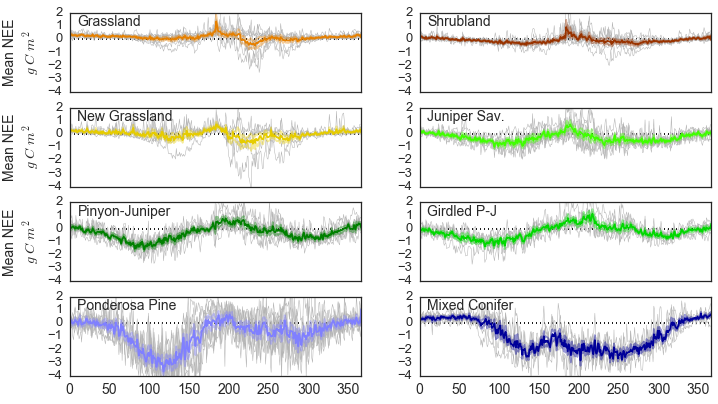

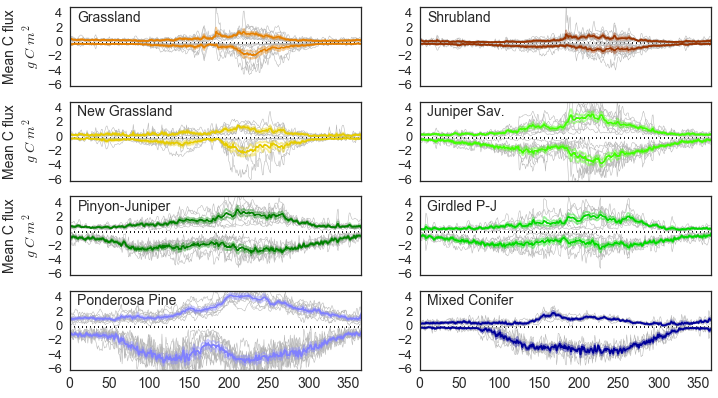

In [43]:
# Plot NEE
ylims = [ -4, 2 ]
xlims = [ 0, 366 ]
highlight_year = [2011]
fig3 = plt.figure(figsize=( 11.5, 6.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_multiyr_mean_sites( fc_clim, 'allyr_mean', 'NEE', 1, fig3, ind_yrs=True,
                        ylims=ylims)     
fig3.savefig( fig_path + 'NMEG_mean_NEE.svg')
fig3.savefig( fig_path + 'NMEG_mean_NEE.png', dpi=200)


# Plot RECO and GPP
ylims = [ -6, 5 ]
fig6 = plt.figure(figsize=( 11.5, 6.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_multiyr_mean_sites( [re_clim, gpp_clim], 'allyr_mean', 'C flux', 3, fig6,
                        ylims=ylims, ind_yrs=True)
fig6.savefig( fig_path + 'NMEG_mean_RECOGPP.svg')
fig6.savefig( fig_path + 'NMEG_mean_RECOGPP.png', dpi=200)

## Plot multiyear C flux means for pre/post/drought

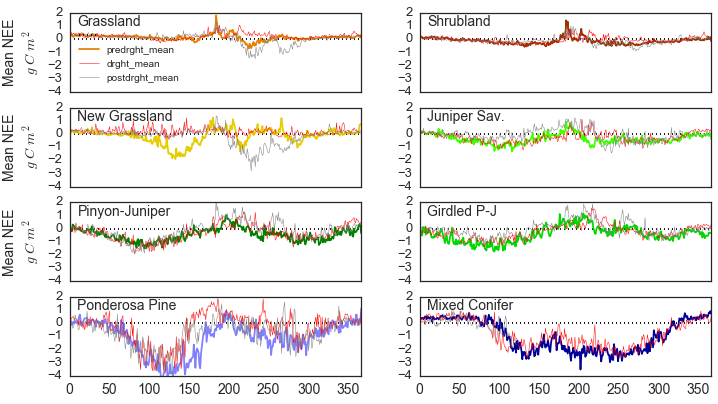

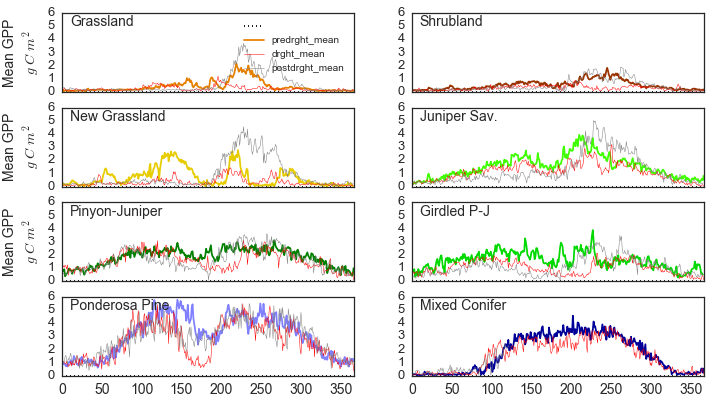

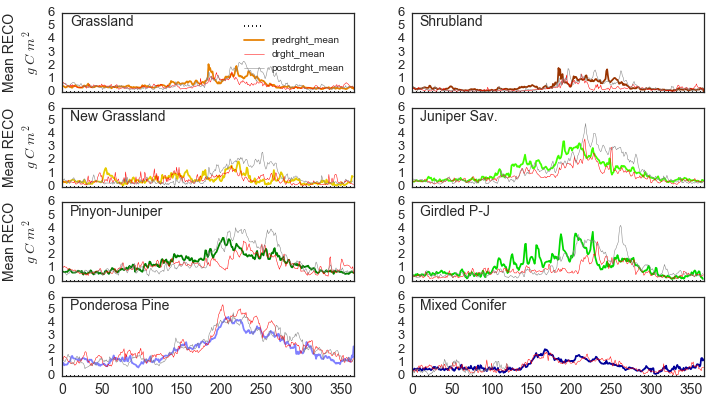

In [44]:
ylims = [ -4, 2 ]

figX = plt.figure(figsize=( 11.5, 6.5 ), dpi=150, facecolor='w', edgecolor='k')
ax = plot_multiyr_mean_sites( fc_clim, ['predrght_mean','drght_mean','postdrght_mean'],
                             'NEE', 1, figX, ind_yrs=False,
                             ylims=ylims, hilite_yr=[None])
ax[0].legend(['','predrght_mean','drght_mean','postdrght_mean'], loc='lower left')

ylims = [ 0, 6 ]
figY = plt.figure(figsize=( 11.5, 6.5 ), dpi=150, facecolor='w', edgecolor='k')
ax = plot_multiyr_mean_sites( gpp_clim, ['predrght_mean','drght_mean','postdrght_mean'],
                             'GPP', 5, figY, ind_yrs=False,
                             ylims=ylims, hilite_yr=[None])
ax[0].legend(['','predrght_mean','drght_mean','postdrght_mean'], loc='upper right')

figZ = plt.figure(figsize=( 11.5, 6.5 ), dpi=150, facecolor='w', edgecolor='k')
ax = plot_multiyr_mean_sites( re_clim, ['predrght_mean','drght_mean','postdrght_mean'],
                             'RECO', 5, figZ, ind_yrs=False,
                             ylims=ylims, hilite_yr=[None])

ax[0].legend(['','predrght_mean','drght_mean','postdrght_mean'], loc='upper right')

## Plot mean daily values for all drought periods

### Limit to growing season

The next several plots are limited to growing season only.

In [45]:
startseas = 90
endseas = 300

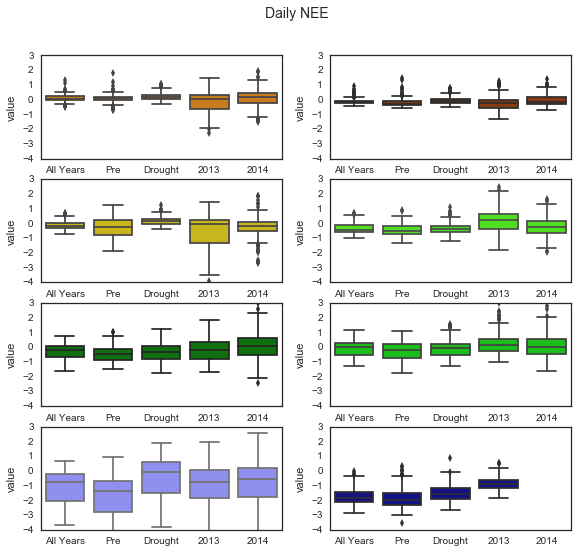

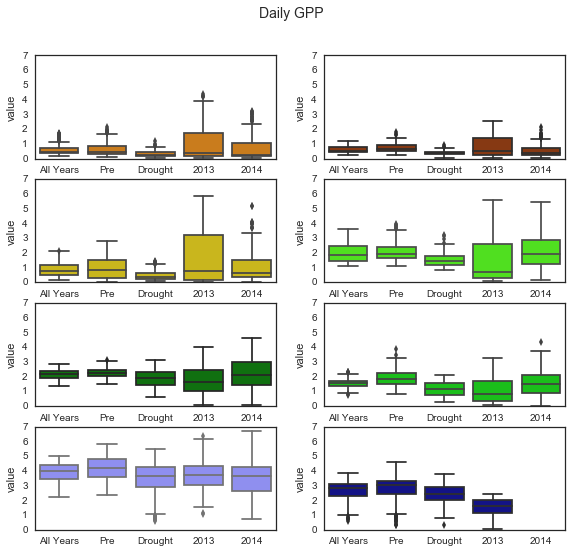

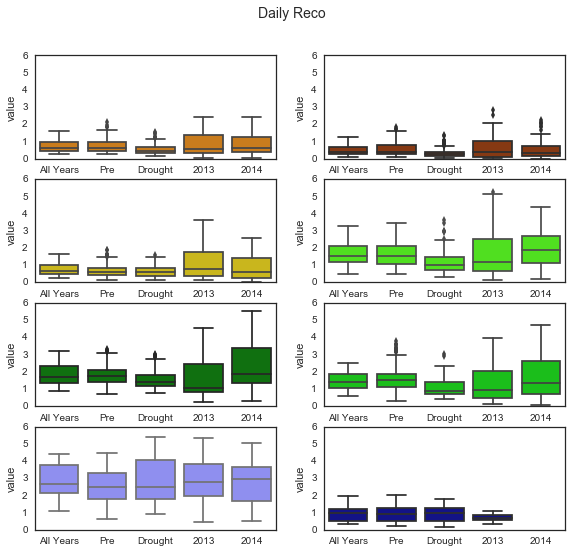

In [49]:
def plot_drought_dist( clim, fig, y_limit, anom=False, preanom=False ):
    for i, site in enumerate(sites):
        # Limit to growing season only
        data = clim[site].iloc[startseas:endseas]
        if anom:
            #subset = pd.melt(data[['predrght_mean_anom', 'drght_mean_anom',
            #                       'postdrght_mean_anom']])
            subset = pd.melt(data[['predrght_mean_anom', 'drght_mean_anom',
                                   '2013_anom', '2014_anom']])
            xlabels = ['Pre', 'Drought', '2013', '2014']
        elif preanom:
            subset = pd.melt(data[['drght_mean_preanom',
                                   '2013_preanom', '2014_preanom']])
            xlabels = ['Drought', '2013', '2014']
        else:
            #subset = pd.melt(data[['allyr_mean','predrght_mean', 'drght_mean',
            #                       'postdrght_mean']])
            subset = pd.melt(data[['allyr_mean','predrght_mean', 'drght_mean',
                                   '2013', '2014']])
            xlabels = ['All Years', 'Pre', 'Drought', '2013', '2014']
        
        ax = fig.add_subplot(len(clim.keys())/2, 2, i+1)    
        sns.boxplot(x='variable', y='value', data=subset, color=nmegplt.palette[site])
        ax.set_xlabel('')
        #ax.set_xticklabels(['Pre', 'Drought', 'Post'])
        ax.set_xticklabels(xlabels)
        ax.set_ylim(y_limit)

figX = plt.figure(figsize=( 9.5, 8.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_drought_dist( fc_clim, figX, [-4, 3])
plt.suptitle('Daily NEE', size=14)
    
figY = plt.figure(figsize=( 9.5, 8.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_drought_dist( gpp_clim, figY, [0, 7])
plt.suptitle('Daily GPP', size=14)

figZ = plt.figure(figsize=( 9.5, 8.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_drought_dist( re_clim, figZ, [0, 6])
plt.suptitle('Daily Reco', size=14)

## Anomalies w/ respect to all year mean

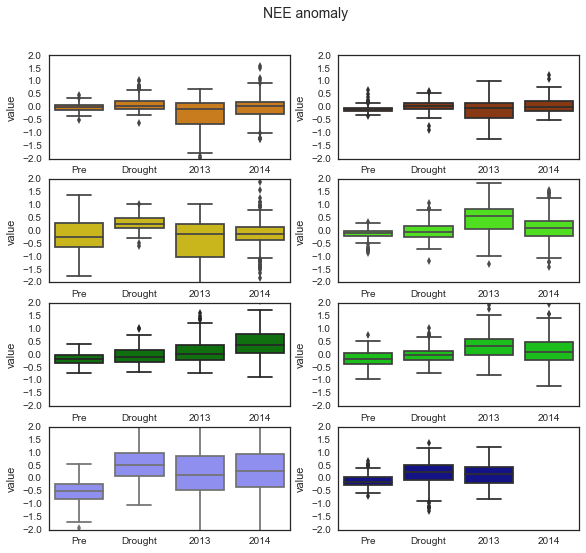

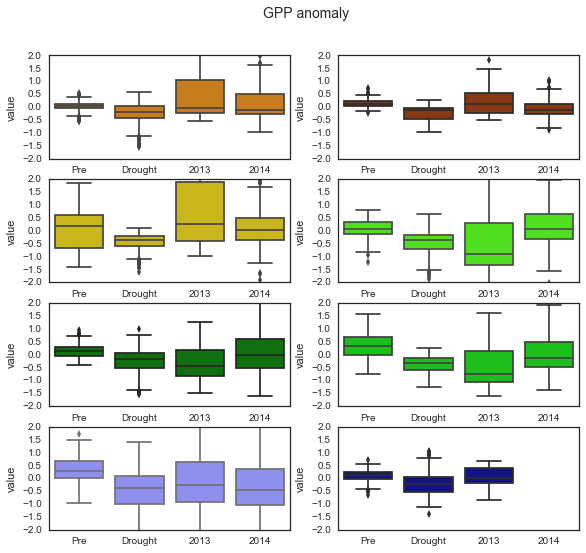

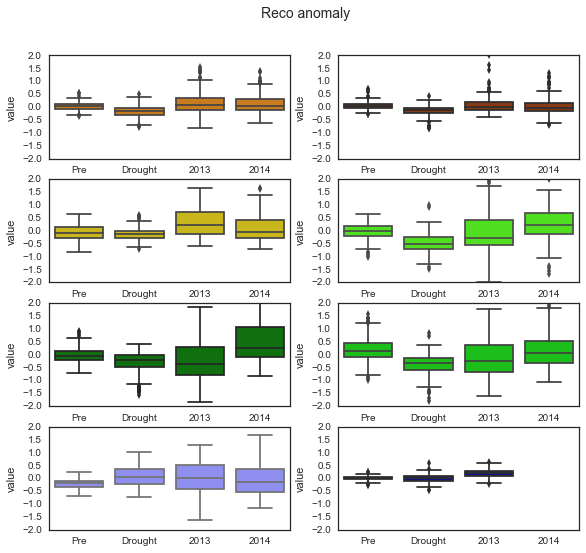

In [50]:
figX = plt.figure(figsize=( 9.5, 8.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_drought_dist( fc_clim, figX, [-2, 2], anom=True)
plt.suptitle('NEE anomaly', size=14)
    
figY = plt.figure(figsize=( 9.5, 8.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_drought_dist( gpp_clim, figY, [-2, 2], anom=True)
plt.suptitle('GPP anomaly', size=14)

figZ = plt.figure(figsize=( 9.5, 8.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_drought_dist( re_clim, figZ, [-2, 2], anom=True)
plt.suptitle('Reco anomaly', size=14)

## Anomalies w/ respect to pre-drought mean (2007-2010)

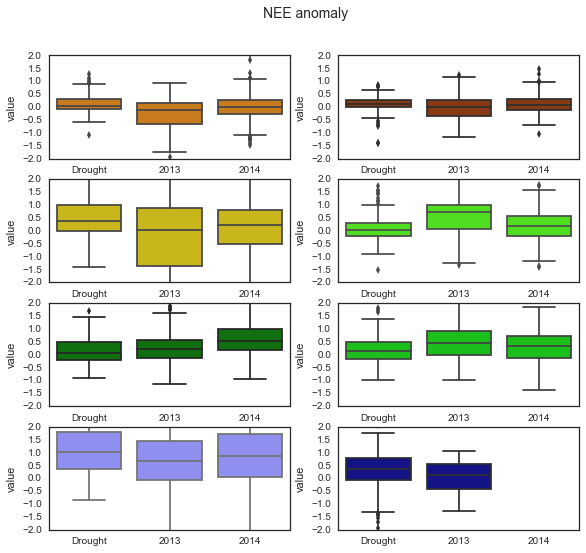

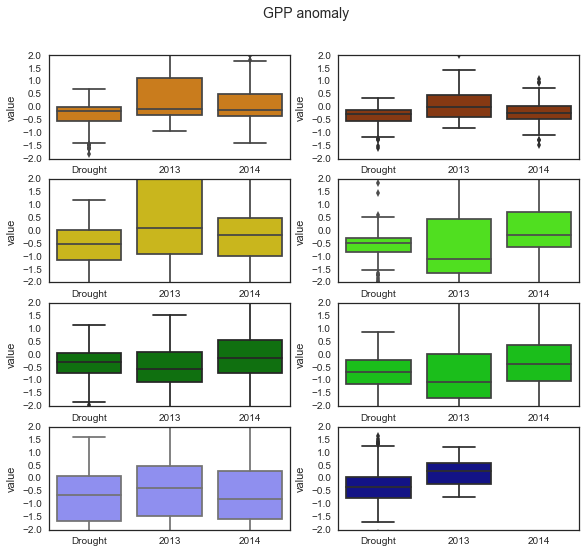

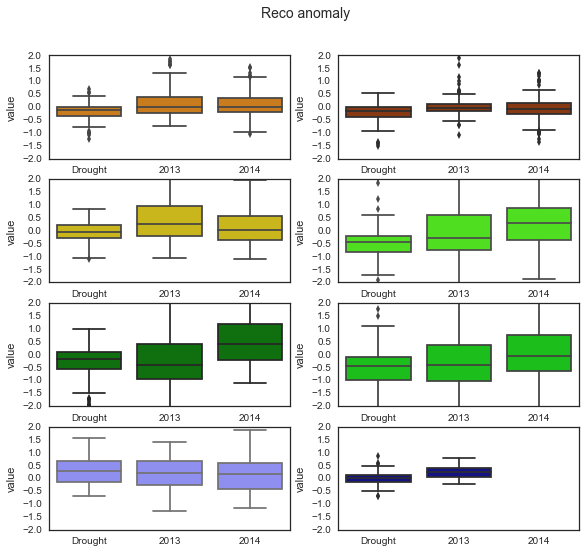

In [51]:
figX = plt.figure(figsize=( 9.5, 8.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_drought_dist( fc_clim, figX, [-2, 2], preanom=True)
plt.suptitle('NEE anomaly', size=14)
    
figY = plt.figure(figsize=( 9.5, 8.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_drought_dist( gpp_clim, figY, [-2, 2], preanom=True)
plt.suptitle('GPP anomaly', size=14)

figZ = plt.figure(figsize=( 9.5, 8.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_drought_dist( re_clim, figZ, [-2, 2], preanom=True)
plt.suptitle('Reco anomaly', size=14)

## Histograms/KDEs of daily flux values

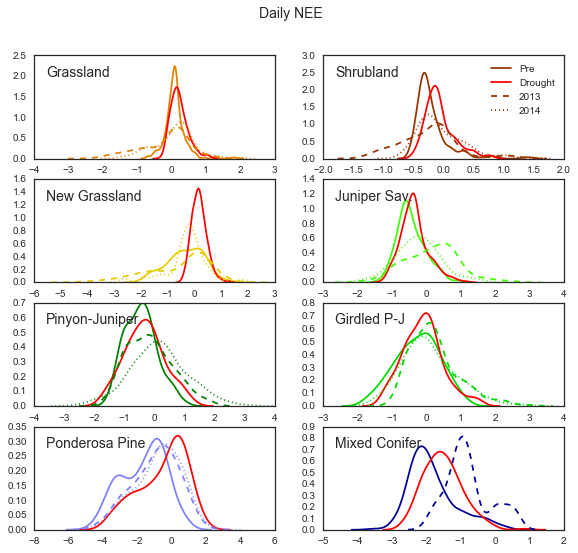

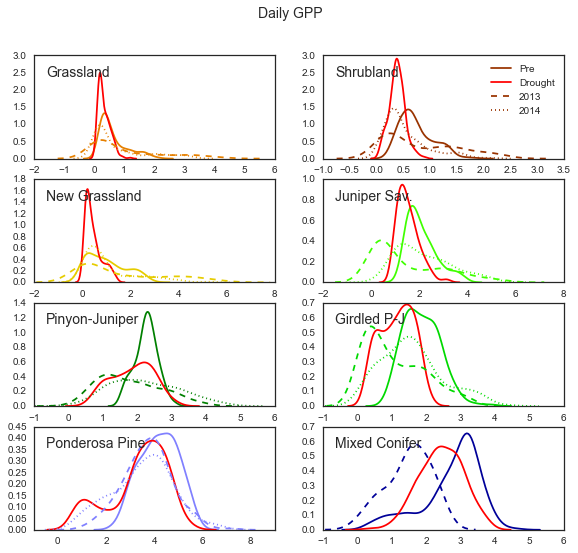

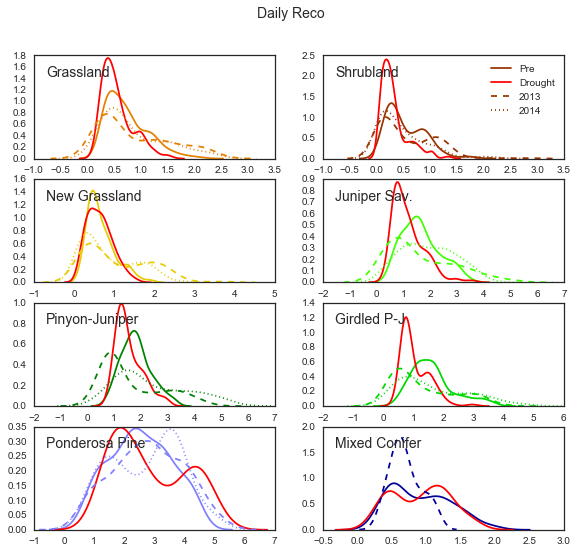

In [54]:
def plot_drought_kde( clim, fig, anom=False, preanom=False ):
    for i, site in enumerate(sites):
        # Limit to growing season only
        data = clim[site].iloc[startseas:endseas]
        ax = fig.add_subplot(len(clim.keys())/2, 2, i+1)
        if anom:
            ax.set_xlim([-2, 2])
            kde_vars = ['predrght_mean_anom','drght_mean_anom','2013_anom','2014_anom']
            legend_label = ['Pre', 'Drought', '2013', '2014']
        elif preanom:
            ax.set_xlim([-2, 2])
            kde_vars = ['drght_mean_preanom','2013_preanom','2014_preanom']
            legend_label = ['Drought', '2013', '2014']
        else:
            #ax.set_xlim([-2, 2])
            kde_vars = ['predrght_mean','drght_mean','2013','2014']
            legend_label = ['Pre', 'Drought', '2013', '2014']
        
        if site!='Vcm' and preanom==False:
            sns.kdeplot(data[kde_vars[0]].dropna(), legend=False, color=nmegplt.palette[site])
            sns.kdeplot(data[kde_vars[1]].dropna(), legend=False, color='red')
            sns.kdeplot(data[kde_vars[2]].dropna(), legend=False, color=nmegplt.palette[site], ls='--')
            sns.kdeplot(data[kde_vars[3]].dropna(), legend=False, color=nmegplt.palette[site], ls=':')
        elif site!='Vcm' and preanom==True:
            sns.kdeplot(data[kde_vars[0]].dropna(), legend=False, color='red')
            sns.kdeplot(data[kde_vars[1]].dropna(), legend=False, color=nmegplt.palette[site])
            sns.kdeplot(data[kde_vars[2]].dropna(), legend=False, color=nmegplt.palette[site], ls='--')
        elif site=='Vcm' and preanom==False:
            sns.kdeplot(data[kde_vars[0]].dropna(), legend=False, color=nmegplt.palette[site])
            sns.kdeplot(data[kde_vars[1]].dropna(), legend=False, color='red')
            sns.kdeplot(data[kde_vars[2]].dropna(), legend=False, color=nmegplt.palette[site], ls='--')
        elif site=='Vcm' and preanom==True:
            sns.kdeplot(data[kde_vars[0]].dropna(), legend=False, color='red')
            sns.kdeplot(data[kde_vars[1]].dropna(), legend=False, color=nmegplt.palette[site])
        
        plt.text( .05, .8, nmegplt.longnames[site], size=14, transform=ax.transAxes  )
        ax.set_xlabel('')
        if i==1:
            #plt.legend(['Pre', 'Post', 'Drought'])
            plt.legend(legend_label)
        
figX = plt.figure(figsize=( 9.5, 8.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_drought_kde(fc_clim, figX)
plt.suptitle('Daily NEE', size=14)
    
figY = plt.figure(figsize=( 9.5, 8.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_drought_kde(gpp_clim, figY)
plt.suptitle('Daily GPP', size=14)

figZ = plt.figure(figsize=( 9.5, 8.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_drought_kde(re_clim, figZ)
plt.suptitle('Daily Reco', size=14)

## Histograms/KDEs of daily anomaly (wrt all years)

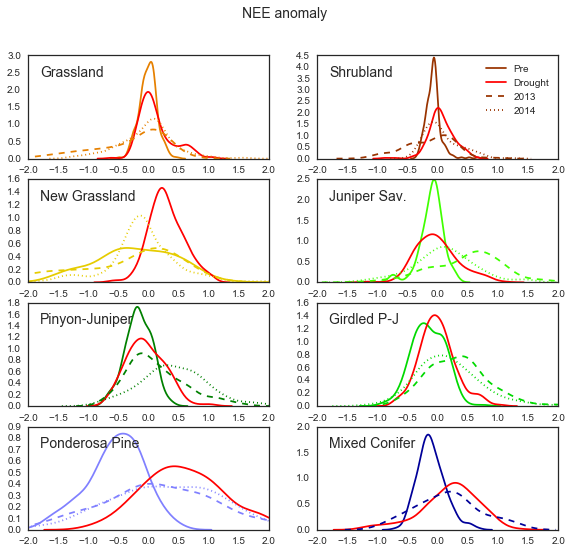

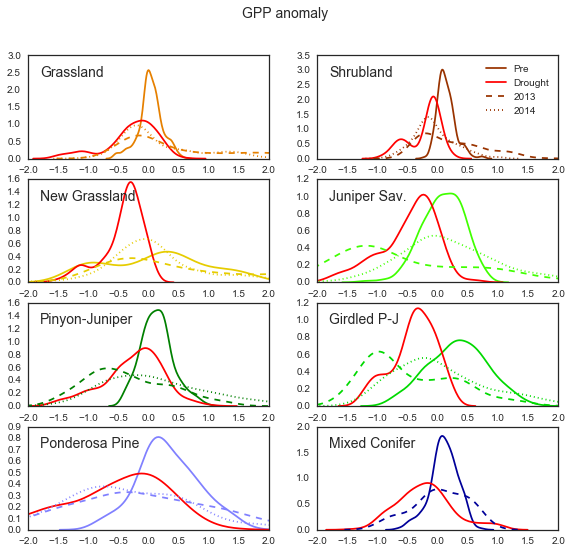

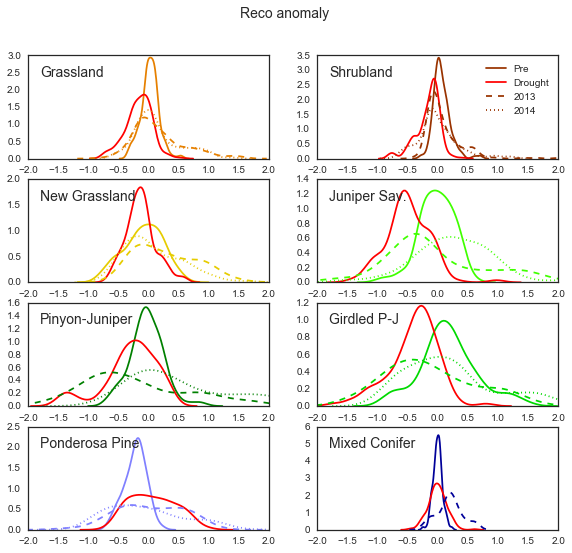

In [55]:
figX = plt.figure(figsize=( 9.5, 8.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_drought_kde(fc_clim, figX, anom=True)
plt.suptitle('NEE anomaly', size=14)
    
figY = plt.figure(figsize=( 9.5, 8.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_drought_kde(gpp_clim, figY, anom=True)
plt.suptitle('GPP anomaly', size=14)

figZ = plt.figure(figsize=( 9.5, 8.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_drought_kde(re_clim, figZ, anom=True)
plt.suptitle('Reco anomaly', size=14)

## Histograms/KDEs of daily anomaly (wrt pre-drought years)

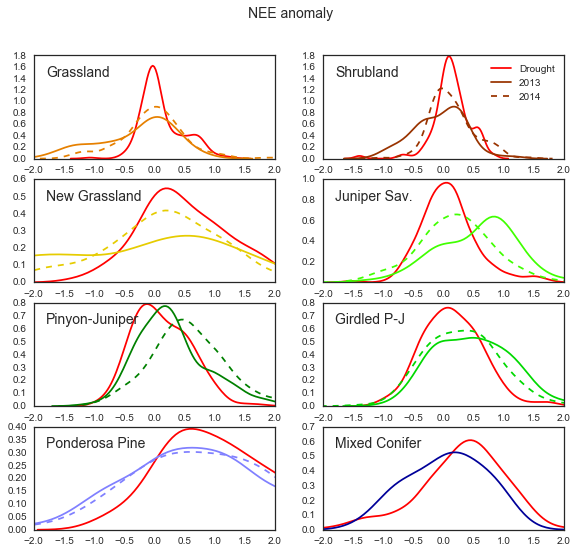

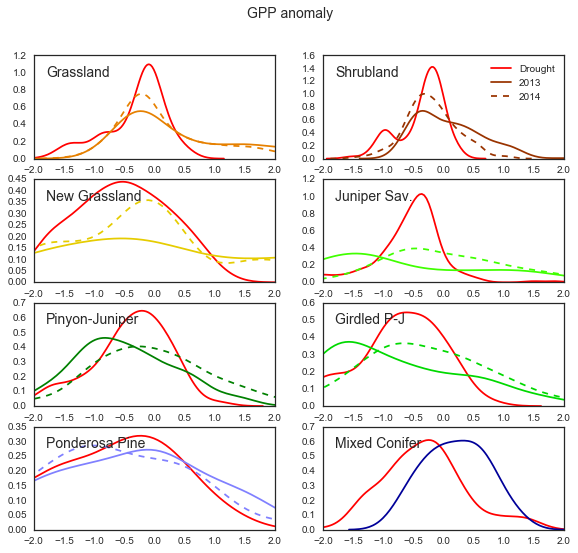

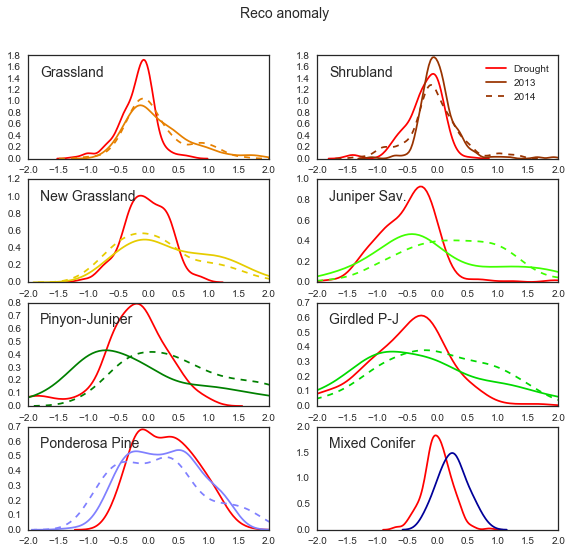

In [56]:
figX = plt.figure(figsize=( 9.5, 8.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_drought_kde(fc_clim, figX, preanom=True)
plt.suptitle('NEE anomaly', size=14)
    
figY = plt.figure(figsize=( 9.5, 8.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_drought_kde(gpp_clim, figY, preanom=True)
plt.suptitle('GPP anomaly', size=14)

figZ = plt.figure(figsize=( 9.5, 8.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_drought_kde(re_clim, figZ, preanom=True)
plt.suptitle('Reco anomaly', size=14)

## Cumulative sums by year

These show cumulative C flux (NEE or GPP) for each year measured.

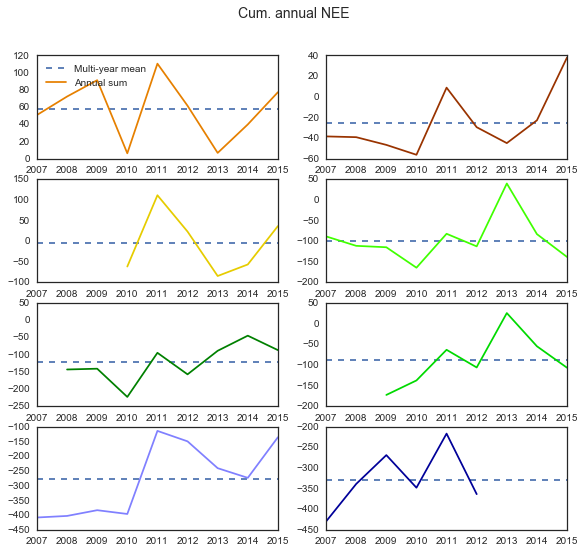

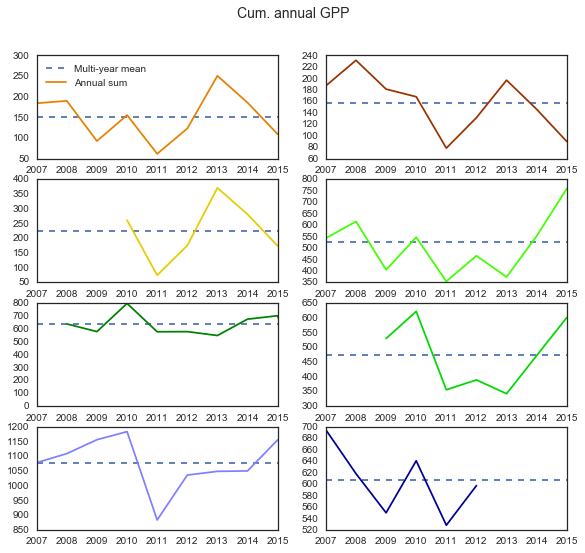

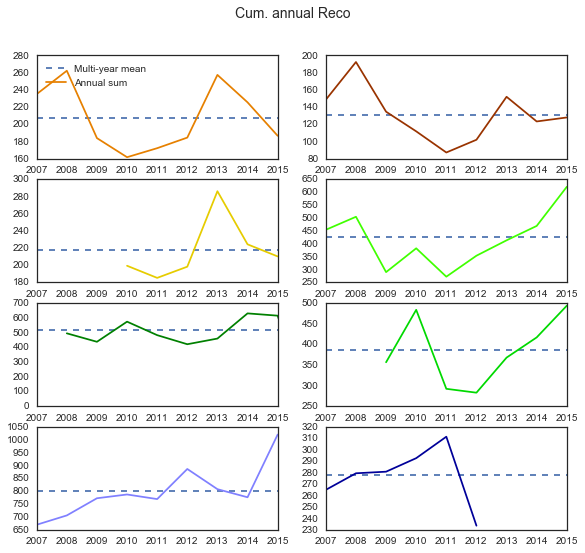

In [64]:
def plot_cumulative_annual( daily_var, clim, fig ):
    for i, site in enumerate(sites):
        ax = fig.add_subplot(len(sites)/2, 2, i+1)
        data = d[site][ daily_var ].groupby(d[site].index.year).sum()
        mean = clim[site].allyr_mean.sum()
        plt.plot([data.index[0], data.index[-1]], [mean, mean], ls='--')
        if site == 'Vcm':
            data = data[data.index < 2013]
        elif site == 'Mpj':
            data = data[data.index > 2007]  
        else:
            data = data[data.index < end+1]
        plt.plot(data.index, data, color=nmegplt.palette[site])
        
        if i == 0:
            plt.legend(['Multi-year mean', 'Annual sum'], loc='upper left')
        plt.xlim([start, end])
        x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
        ax.xaxis.set_major_formatter(x_formatter)
        #print(data.GPP_g_int.sum())

figX = plt.figure(figsize=( 9.5, 8.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_cumulative_annual( 'FC_F_g_int', fc_clim, figX )
plt.suptitle('Cum. annual NEE', size=14)

figY = plt.figure(figsize=( 9.5, 8.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_cumulative_annual( 'GPP_g_int', gpp_clim, figY )
plt.suptitle('Cum. annual GPP', size=14)

figZ = plt.figure(figsize=( 9.5, 8.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_cumulative_annual( 'RECO_g_int', re_clim, figZ )
plt.suptitle('Cum. annual Reco', size=14)


## Table of cumulative values

* Summed g C/m2 during the different periods we are interested in (pre-, post-, drought, and all year means)
* Differences between pre-drought/potential cumulative values and and drought/post-drought periods
* Percentage of pre-drought and potential cumulative flux


In [71]:
indices = ['AllYr Mean', 'Pre','Drought', 'Post', 'Potential', 
           'Pre-Drought', 'Drought % of pre', 'Pre-Post','Post % of pre',
           'Pot.-Drought', 'Drought % of pot.', 'Pot.-Post', 'Post % of pot.']
nee_t = pd.DataFrame(columns=sites, index = indices)
gpp_t = pd.DataFrame(columns=sites, index = indices)
reco_t = pd.DataFrame(columns=sites, index = indices)

for i, site in enumerate(sites):
        
    # Sum up the climatology columns for the site
    sums = fc_clim[site].sum()
    nee_t[site].loc['AllYr Mean'] = sums.allyr_mean
    nee_t[site].loc['Pre'] = sums.predrght_mean
    nee_t[site].loc['Drought'] = sums.drght_mean
    nee_t[site].loc['Post'] = sums.postdrght_mean
    nee_t[site].loc['Pre-Drought'] = sums.predrght_mean - sums.drght_mean
    nee_t[site].loc['Drought % of pre'] = (sums.drght_mean / sums.predrght_mean) * 100
    nee_t[site].loc['Pre-Post'] = sums.predrght_mean - sums.postdrght_mean
    nee_t[site].loc['Post % of pre'] = (sums.postdrght_mean / sums.predrght_mean) * 100
    
    sums = gpp_clim[site].sum()
    gpp_t[site].loc['AllYr Mean'] = sums.allyr_mean
    gpp_t[site].loc['Pre'] = sums.predrght_mean
    gpp_t[site].loc['Drought'] = sums.drght_mean
    gpp_t[site].loc['Post'] = sums.postdrght_mean
    gpp_t[site].loc['Pre-Drought'] = sums.predrght_mean - sums.drght_mean
    gpp_t[site].loc['Drought % of pre'] = (sums.drght_mean / sums.predrght_mean) * 100
    gpp_t[site].loc['Pre-Post'] = sums.predrght_mean - sums.postdrght_mean
    gpp_t[site].loc['Post % of pre'] = (sums.postdrght_mean / sums.predrght_mean) * 100
    
    sums = re_clim[site].sum()
    reco_t[site].loc['AllYr Mean'] = sums.allyr_mean
    reco_t[site].loc['Pre'] = sums.predrght_mean
    reco_t[site].loc['Drought'] = sums.drght_mean
    reco_t[site].loc['Post'] = sums.postdrght_mean
    reco_t[site].loc['Pre-Drought'] = sums.predrght_mean - sums.drght_mean
    reco_t[site].loc['Drought % of pre'] = (sums.drght_mean / sums.predrght_mean) * 100
    reco_t[site].loc['Pre-Post'] = sums.predrght_mean - sums.postdrght_mean
    reco_t[site].loc['Post % of pre'] = (sums.postdrght_mean / sums.predrght_mean) * 100
    
nee_t

Seg      Ses      Sen      Wjs      Mpj      Mpg  \
AllYr Mean         57.4223 -25.7437 -5.36149 -99.5031 -122.769 -87.8415   
Pre                55.2135 -45.2686 -61.6386 -134.059  -169.65 -155.439   
Drought            86.0908 -10.3374  67.1492 -97.3292 -126.118 -84.7693   
Post               23.2075  -33.917 -70.6572 -21.7236 -67.1667 -14.7515   
Potential              NaN      NaN      NaN      NaN      NaN      NaN   
Pre-Drought       -30.8773 -34.9312 -128.788 -36.7293 -43.5321 -70.6697   
Drought % of pre   155.924  22.8358  -108.94   72.602    74.34  54.5354   
Pre-Post            32.006 -11.3516   9.0186 -112.335 -102.483 -140.688   
Post % of pre      42.0324  74.9238  114.631  16.2046  39.5914  9.49021   
Pot.-Drought           NaN      NaN      NaN      NaN      NaN      NaN   
Drought % of pot.      NaN      NaN      NaN      NaN      NaN      NaN   
Pot.-Post              NaN      NaN      NaN      NaN      NaN      NaN   
Post % of pot.         NaN      NaN      NaN      NaN      NaN      NaN   

                       Vcp      Vcm  
AllYr Mean        -277.541 -329.085  
Pre               -396.876 -345.787  
Drought           -131.534 -289.881  
Post               -257.21 -11.5102  
Potential              NaN      NaN  
Pre-Drought       -265.342 -55.9061  
Drought % of pre   33.1423  83.8322  
Pre-Post          -139.666 -334.277  
Post % of pre      64.8087  3.32869  
Pot.-Drought           NaN      NaN  
Drought % of pot.      NaN      NaN  
Pot.-Post              NaN      NaN  
Post % of pot.         NaN      NaN

In [72]:
gpp_t

Seg      Ses      Sen      Wjs      Mpj      Mpg  \
AllYr Mean         150.379  156.842  222.615  524.491  636.362  472.682   
Pre                155.672  192.141   260.93  559.838  671.173  575.249   
Drought            92.3454  104.944  124.625  410.157  577.026  372.163   
Post               218.256  171.508  325.808  462.622  610.931  406.742   
Potential              NaN      NaN      NaN      NaN      NaN      NaN   
Pre-Drought        63.3263  87.1971  136.305  149.681   94.147  203.085   
Drought % of pre   59.3206  54.6182  47.7618  73.2636  85.9728  64.6961   
Pre-Post          -62.5839  20.6333 -64.8778   97.216  60.2415  168.507   
Post % of pre      140.203  89.2614  124.864   82.635  91.0244  70.7072   
Pot.-Drought           NaN      NaN      NaN      NaN      NaN      NaN   
Drought % of pot.      NaN      NaN      NaN      NaN      NaN      NaN   
Pot.-Post              NaN      NaN      NaN      NaN      NaN      NaN   
Post % of pot.         NaN      NaN      NaN      NaN      NaN      NaN   

                       Vcp      Vcm  
AllYr Mean         1078.07  607.092  
Pre                1132.26  626.099  
Drought            959.766  562.646  
Post               1049.12  78.6428  
Potential              NaN      NaN  
Pre-Drought        172.494  63.4535  
Drought % of pre   84.7655  89.8653  
Pre-Post           83.1395  547.456  
Post % of pre      92.6572  12.5608  
Pot.-Drought           NaN      NaN  
Drought % of pot.      NaN      NaN  
Pot.-Post              NaN      NaN  
Post % of pot.         NaN      NaN

In [73]:
reco_t

Seg      Ses      Sen      Wjs      Mpj      Mpg  \
AllYr Mean         207.801  131.098  217.254  424.988  513.593  384.841   
Pre                210.885  146.872  199.292   425.78  501.523   419.81   
Drought            178.436  94.6065  191.774  312.828  450.908  287.394   
Post               241.463  137.591  255.151  440.899  543.764  391.991   
Potential              NaN      NaN      NaN      NaN      NaN      NaN   
Pre-Drought        32.4489   52.266  7.51732  112.951  50.6149  132.416   
Drought % of pre    84.613   64.414   96.228  73.4719  89.9078  68.4582   
Pre-Post          -30.5779  9.28168 -55.8593  -15.119 -42.2416  27.8192   
Post % of pre        114.5  93.6805  128.029  103.551  108.423  93.3734   
Pot.-Drought           NaN      NaN      NaN      NaN      NaN      NaN   
Drought % of pot.      NaN      NaN      NaN      NaN      NaN      NaN   
Pot.-Post              NaN      NaN      NaN      NaN      NaN      NaN   
Post % of pot.         NaN      NaN      NaN      NaN      NaN      NaN   

                       Vcp      Vcm  
AllYr Mean         800.527  278.007  
Pre                735.383  280.312  
Drought            828.232  272.764  
Post                791.91  67.1326  
Potential              NaN      NaN  
Pre-Drought       -92.8487  7.54742  
Drought % of pre   112.626  97.3075  
Pre-Post          -56.5265  213.179  
Post % of pre      107.687  23.9493  
Pot.-Drought           NaN      NaN  
Drought % of pot.      NaN      NaN  
Pot.-Post              NaN      NaN  
Post % of pot.         NaN      NaN

## Pre-Post-During Drought calculations

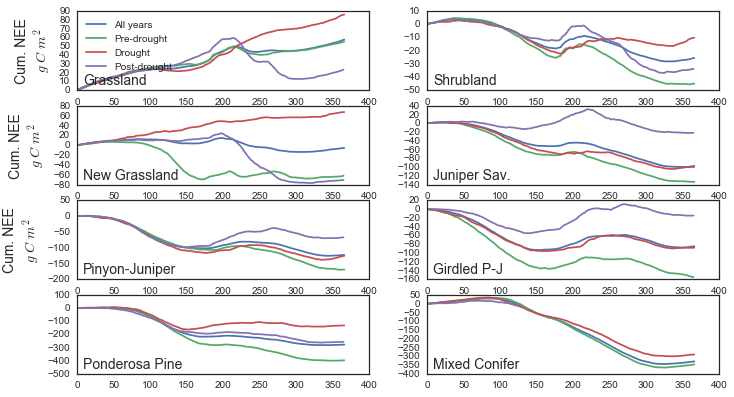

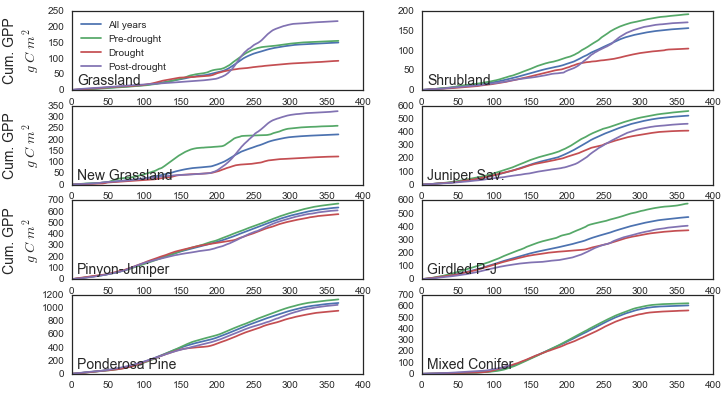

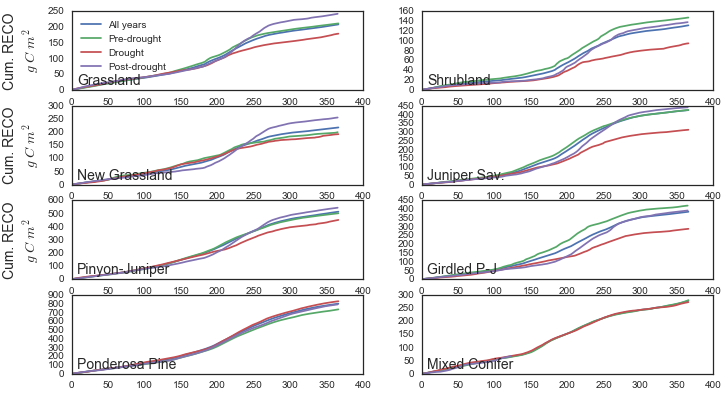

In [75]:
def plot_cumulative_drought( clim, fig, label ):
    ax = list();
    for i, site in enumerate(sites):
        ax.append(fig.add_subplot(len(sites)/2, 2, i+1))
        plt.plot( clim[site].index,  np.cumsum(clim[site].allyr_mean))
        plt.plot( clim[site].index,  np.cumsum(clim[site].predrght_mean))
        plt.plot( clim[site].index,  np.cumsum(clim[site].drght_mean))
        plt.plot( clim[site].index,  np.cumsum(clim[site].postdrght_mean))
            
        #plt.xlim( xlims )
        plt.text( .02, .07, nmegplt.longnames[site], size=14, transform=ax[i].transAxes )
        if i==0:
            plt.legend(['All years', 'Pre-drought', 'Drought','Post-drought'], loc='upper left')

    for i in (0, 2, 4):
            ax[i].set_ylabel('Cum. {0}\n$g\ C\ m^2$'.format(label), fontsize=14)
            
figX = plt.figure(figsize=( 11.5, 6.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_cumulative_drought( fc_clim, figX, 'NEE' )

figY = plt.figure(figsize=( 11.5, 6.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_cumulative_drought( gpp_clim, figY, 'GPP' )

figZ = plt.figure(figsize=( 11.5, 6.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_cumulative_drought( re_clim, figZ, 'RECO' )

## Plot monthly mean anomalies

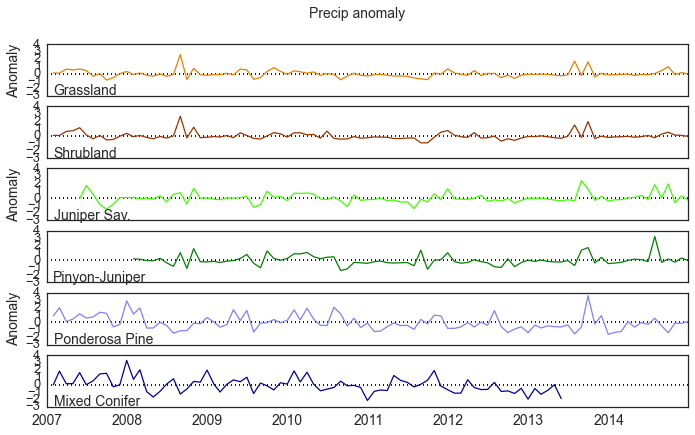

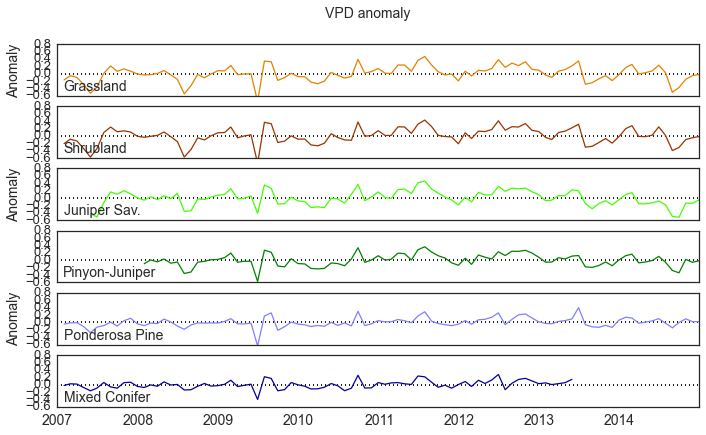

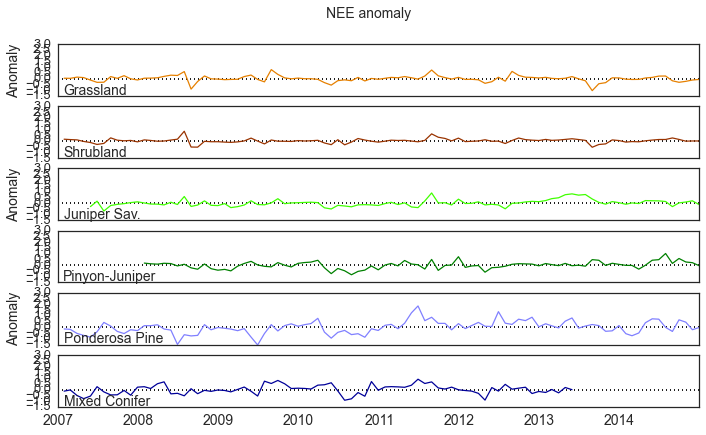

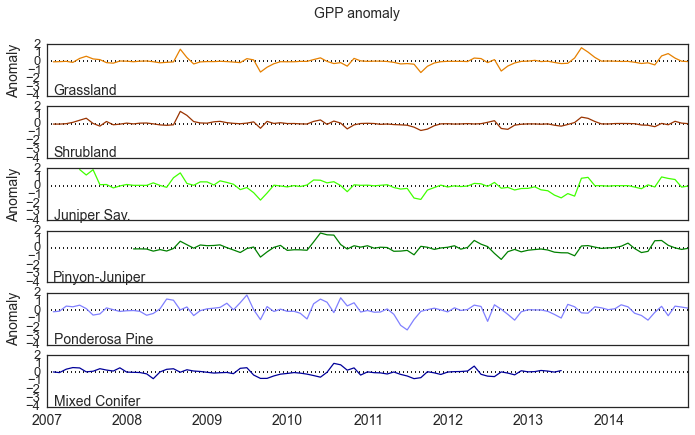

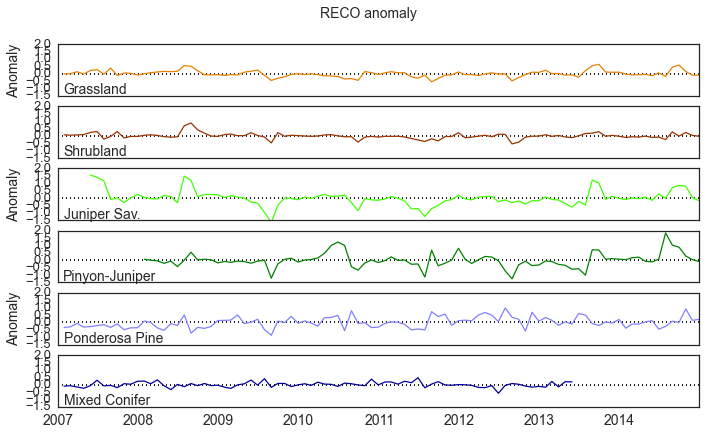

In [27]:
xlims = [ dt.datetime( 2007, 1, 1 ), dt.datetime( 2014, 12, 31 )]

varlist = ['P_F','VPD_F','NEE_g_int','GPP_g_int','RECO_g_int']
ylabs = ['Precip anomaly', 'VPD anomaly', 'NEE anomaly', 'GPP anomaly', 'RECO anomaly']
ylims = [[-3, 4],[-0.6,0.8],[-1.5,3],[-4,2],[-1.5,2]]

for i, anom in enumerate([p_anom, vpd_anom, fc_anom, gpp_anom, re_anom]):
    # Resample anomaly to monthly mean
    anom_m = { i : anom[i].resample('1M', how='mean') for i in anom.keys() }
    
    fig = plt.figure(figsize=( 11.5, 6.5 ), dpi=150, facecolor='w', edgecolor='k')
    nmegplt.plot_tseries( anom_m, varlist[i], ylims[i][0]+0.15, fig, 'Anomaly', ylims=ylims[i])
    plt.suptitle(ylabs[i], size=14)


## Plot monthly mean normalized C flux anomaly

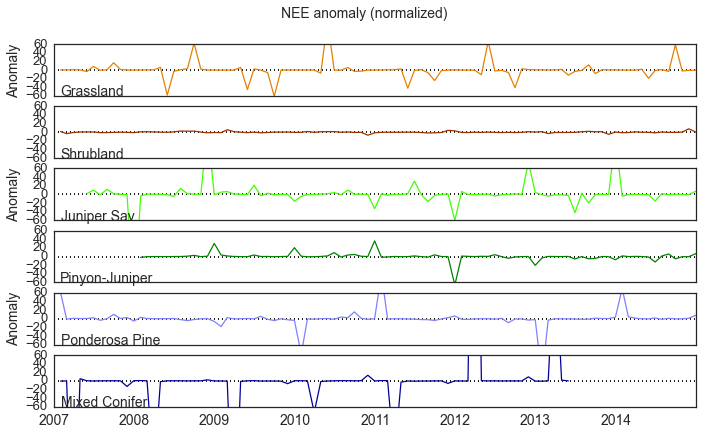

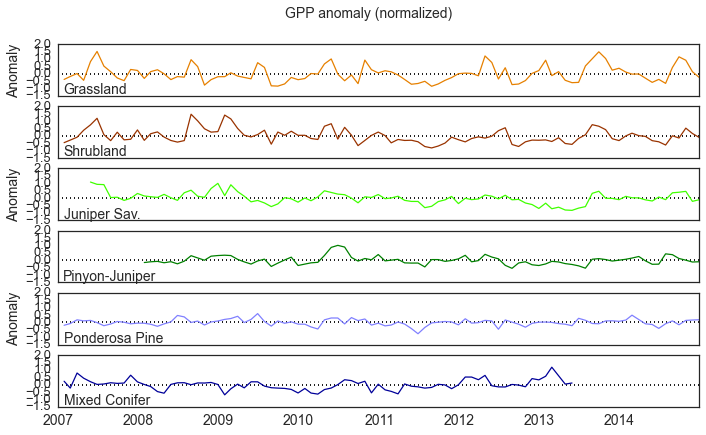

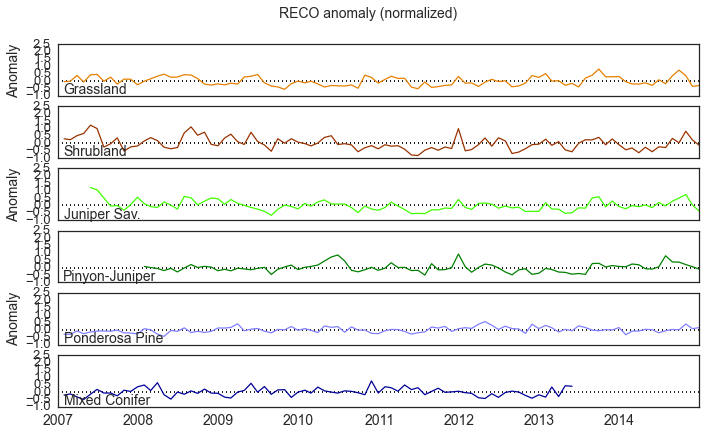

In [28]:
varlist = ['NEE_g_int','GPP_g_int','RECO_g_int']
ylabs = ['NEE anomaly', 'GPP anomaly', 'RECO anomaly']
ylims = [[-60,60],[-1.5,2],[-1,2.5]]

for i, anom in enumerate([fc_anom_n, gpp_anom_n, re_anom_n]):
    
    anom_m = { i : anom[i].resample('1M', how='mean') for i in anom.keys() }
    
    fig = plt.figure(figsize=( 11.5, 6.5 ), dpi=150, facecolor='w', edgecolor='k')
    nmegplt.plot_tseries( anom_m, varlist[i], ylims[i][0]+0.15, fig, 'Anomaly', ylims=ylims[i])
    plt.suptitle(ylabs[i] + ' (normalized)', size=14)
    


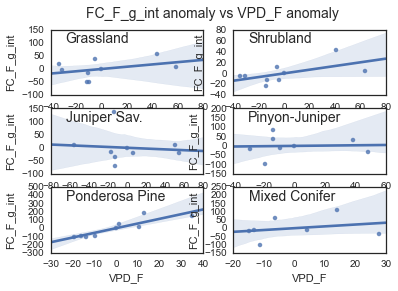

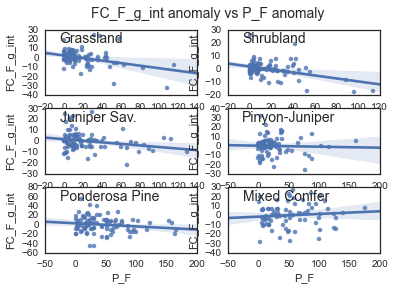

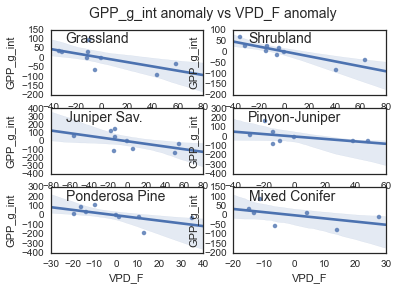

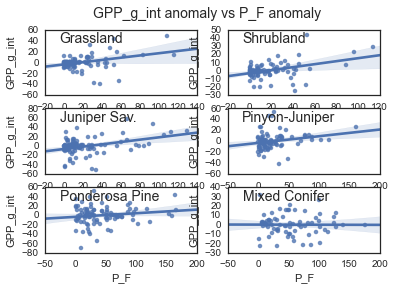

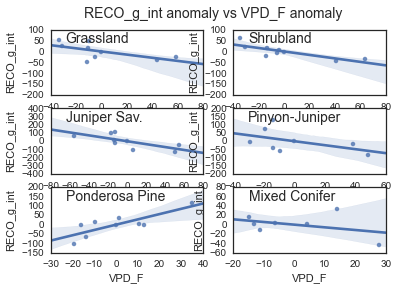

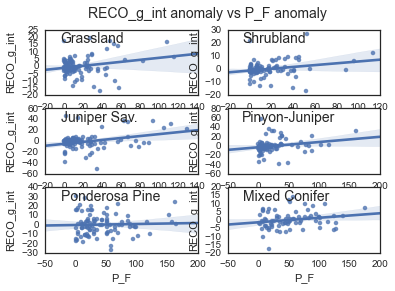

In [29]:
texty = 20
figX = plt.figure()

x_anoms = [vpd_anom, p_anom]
x_labels = ['VPD_F', 'P_F']
y_anoms = [fc_anom, gpp_anom, re_anom]
y_labels = [ 'FC_F_g_int', 'GPP_g_int', 'RECO_g_int']

for i in range(0, 3):
    figA = plt.figure()
    x_anom = x_anoms[0]
    y_anom = y_anoms[i]
    
    for j, site in enumerate(sites):
        x_y_anom = x_anom[ site ].resample('A',how='sum')
        y_y_anom = y_anom[ site ].resample('A',how='sum')
        df = pd.concat([x_y_anom, y_y_anom], axis=1)
        ax = figA.add_subplot(3, 2, j+1)
        sns.regplot(x_labels[0], y_labels[i], df)
        plt.text( .1, .8, nmegplt.names[j], size=14, transform = ax.transAxes  )
    plt.suptitle( y_labels[i] + ' anomaly vs ' + x_labels[0] + ' anomaly', size=14)
    
    figB = plt.figure()
    x_anom = x_anoms[1]
    
    
    for k, site in enumerate(sites):
        # Yearly summed precip
        x_y_anom = d[ site ].P_F.resample('M',how='sum')
        # Yearly summed precip anomaly
        #x_y_anom = x_anom[ site ].resample('M',how='sum')
        y_y_anom = y_anom[ site ].resample('M',how='sum')
        y_y_anom = y_y_anom.shift(-1)
        
        df = pd.concat([x_y_anom, y_y_anom], axis=1)
        ax = figB.add_subplot(3, 2, k+1)
        sns.regplot(x_labels[1], y_labels[i], df)
        plt.text( .1, .8, nmegplt.names[k], size=14, transform = ax.transAxes  )
    plt.suptitle( y_labels[i] + ' anomaly vs ' + x_labels[1] + ' anomaly', size=14)
